In [61]:
import pitchfork.pitchfork as pitchfork
from pitchfork.pitchfork.pitchfork import Review # For restoring saved reviews
from bs4 import BeautifulSoup
from string import punctuation
import json
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import time
FS = 18

In [2]:
import seaborn as sns
sns.set(color_codes=True)
np.random.seed(sum(map(ord, "regression")))

# Load and format the artist lyrics

In [3]:
# Load the lyrics
artists_rap = json.load(open('lyrics/rap_lyrics.json'))
artists_rock = json.load(open('lyrics/rock_lyrics.json'))
artists_country = json.load(open('lyrics/country_lyrics.json'))
artists_raw = artists_rap + artists_rock + artists_country

In [4]:
# Determine
def getArtistImage(songs):    
    urls = [None]
    for song in songs:
        if song['raw']['album'] is not None:
            try:                
                urls.append(song['raw']['album']['artist']['image_url'])                
            except:
                pass
    
    return Counter(urls).most_common()[0][0] # Most common image

# Use a generator to exclude artists with too few songs
def filterBySongCount(artists, min_count=10, max_count=10000):
    for artist in artists:        
        num_songs = len(artist['songs'])
        if (num_songs >= min_count) and (num_songs < max_count): yield artist

min_songs, max_songs = 10, 2500
artists = list(filterBySongCount(artists_raw, min_songs, max_songs))

# Artist images
for artist in artists:
    artist['image_url'] = getArtistImage(artist['songs'])
    
    # Kludge
    if artist['artist'] == 'Black Thought':
        artist['image_url'] = 'https://images.genius.com/23de511f4ac50d900128ea363b7d81b3.450x320x1.jpg'
    if artist['artist'] == 'André 3000':
        artist['image_url'] = 'http://images.genius.com/64b15c9489c65f5bf8f6577334347404.434x434x1.jpg'            
        
# Gender
labels_gender = np.array([a['gender'] for a in artists])
mask_female = np.array([g=='female' for g in labels_gender])
mask_male   = np.array([g=='male'   for g in labels_gender])
print("You have lyrics from {} artists, with a minimum of {} songs per artist.\nFemale: {}, male: {}"
      .format(len(artists), min_songs, (labels_gender=='female').sum(), (labels_gender=='male').sum()))

# Add all song lyrics to a single list
all_songs = []
for artist, gender in zip(artists, labels_gender):
    for song in artist['songs']:        
        song['gender'] = gender
        all_songs.append(song)
              
song_count = len(all_songs)
print("Database contains {} songs.".format(song_count))

# Store all lyrics in a single string
all_lyrics = " ".join([song['lyrics'] for song in all_songs])

You have lyrics from 303 artists, with a minimum of 10 songs per artist.
Female: 79, male: 222
Database contains 58239 songs.


# Load the Pitchfork album reviews

In [5]:
filename_album_reviews = "./album_reviews.pickle"
if os.path.exists(filename_album_reviews) and os.path.getsize(filename_album_reviews) > 0:
    artist_reviews = pickle.load(open(filename_album_reviews, 'rb'))    

## Convert the reviews from JSON string to Pitchfork Review format

In [6]:
def convert_json_to_review(review_as_string):
    json_obj = json.loads(review_as_string)
    return Review(json_obj['searched_artist'], json_obj['searched_album'],
                  json_obj['matched_artist'], json_obj['matched_album'],
                  json_obj['query'], json_obj['url'], BeautifulSoup(json_obj['soup'], "lxml"))

In [7]:
# Convert to Review format
all_reviews = {}
for name, albums in artist_reviews.items():
    print(name)
    album_reviews = []
    for album, review in albums.items():
        album_reviews.append(convert_json_to_review(review))
    all_reviews[name] = album_reviews
    
# List of all artist names with reviews
artist_names_with_reviews = list(all_reviews.keys())
print('\nDone.')

Kanye West
The Beatles
2Pac
Eminem
The Notorious B.I.G.
Nas
Ice Cube
JAY-Z
Snoop Dogg
Dr. Dre
Kendrick Lamar
A$AP Rocky
50 Cent
Busta Rhymes
J. Cole
Method Man
KRS-One
Ludacris
Lil Wayne
Common
Ghostface Killah
T.I.
Lauryn Hill
Scarface
Raekwon
The Game
Ol' Dirty Bastard
Mobb Deep
Logic
Chance The Rapper
Cypress Hill
Lupe Fiasco
RZA
GZA
Warren G
Q-Tip
Talib Kweli
Missy Elliott
Immortal Technique
Big Sean
Kid Cudi
Twista
Big Boi
Drake
Wiz Khalifa
Eric B. & Rakim
ScHoolboy Q
Run-D.M.C.
Hopsin
Nelly
Tyler, The Creator
Jadakiss
Kurupt
Grandmaster Flash & The Furious Five
N.W.A
Gang Starr
E-40
Pusha T
De La Soul
Yelawolf
Earl Sweatshirt
Fabolous
Mac Miller
Jeezy
Kodak Black
2 Chainz
Chief Keef
Gucci Mane
Salt-N-Pepa
Lil' Kim
Nicki Minaj
M.I.A.
Azealia Banks
Angel Haze
DeJ Loaf
Jean Grae
Ciara
Estelle
Tink
The Kinks
The Beach Boys
Bruce Springsteen
Alice in Chains
ZZ Top
Green Day
Neil Young
Tom Petty and the Heartbreakers
Foo Fighters
Grateful Dead
Rush
Red Hot Chili Peppers
Michael Jackson

## Only keep artists that have reviews

In [8]:
artists = [artist for artist in artists if artist['artist'] in artist_names_with_reviews]

## Extract data from the Pitchfork reviews (scores, years, etc.)

In [9]:
scores, years, reviews_per_artist = [], [], []
male_scores, female_scores = [],[]
for artist in artists:
    name = artist['artist']
    if name in all_reviews:
        # Collect information from the review
        num_reviews = 0
        for r in all_reviews[name]:
            year = r.year().split('/')[0] # Album year
            score = r.score() # Review score
            if year != "":
                num_reviews += 1
                years.append(int(year))  # Album year
                scores.append(score) # Review score

                # Store scores by gender
                if artist['gender'] == 'male':
                    male_scores.append(score)
                elif artist['gender'] == 'female':
                    female_scores.append(score)
        reviews_per_artist.append(num_reviews)
                                
# Group together scores into single list
reviews_per_artist = np.array(reviews_per_artist)
scores = np.array(scores)
years = np.array(years)
scores_by_gender = [male_scores, female_scores]

## How many reviews do we have for each artist?

Total number of artists: 143
Total number of reviews: 581
Median of 3 reviews per artist.


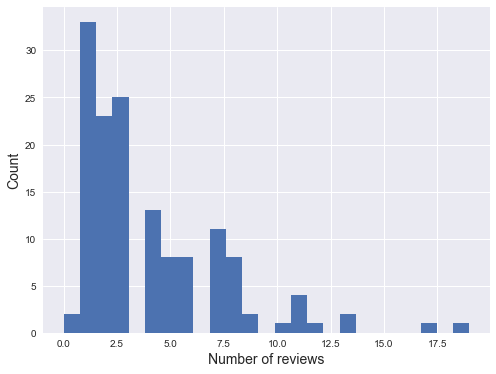

In [10]:
print("Total number of artists: {}".format(len(reviews_per_artist)))
print("Total number of reviews: {}".format(reviews_per_artist.sum()))
print("Median of {:1.0f} reviews per artist.".format(np.median(reviews_per_artist)))

fig, ax = plt.subplots(figsize=(8,6))
ax.hist(reviews_per_artist, 25)
ax.set_xlabel("Number of reviews", fontsize=FS)
ax.set_ylabel("Count", fontsize=FS)
plt.show()

## Playing with list comprehensions...

In [218]:
all_scores = [[review.score() for review in reviews] for reviews in all_reviews.values()]

In [223]:
all_years = [[review.year().split("/")[0] for review in reviews] for reviews in all_reviews.values()]

## Pitchfork reviews over time

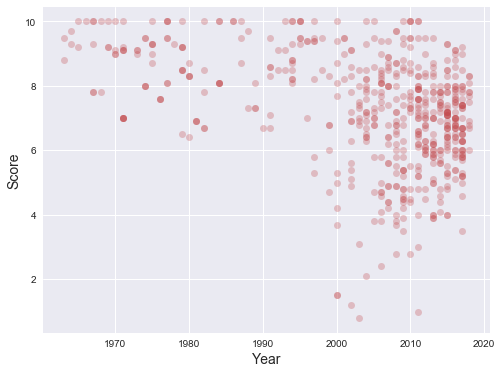

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(years, scores, 'ro', alpha=0.3)
ax.set_xlabel("Year", fontsize=FS)
ax.set_ylabel("Score", fontsize=FS)
plt.show()

## Pitchfork review scores separated by gender

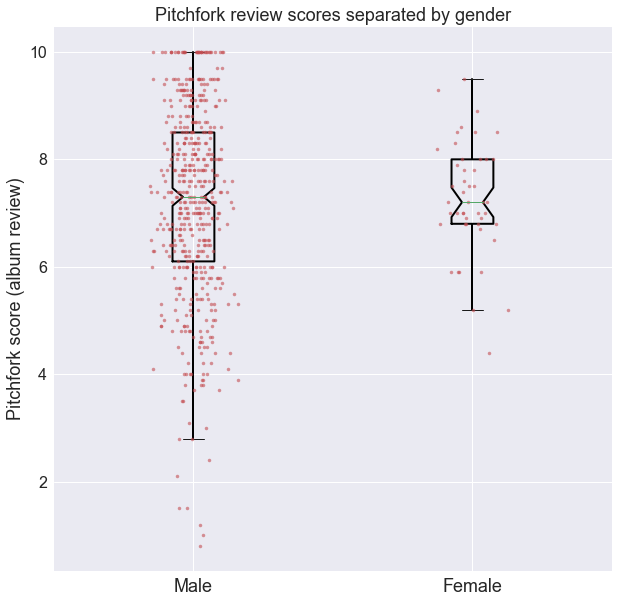

In [54]:
fig, ax = plt.subplots(figsize=(10,10))
boxprops = dict(linestyle='-', linewidth=2, color='black')
whiskerprops = dict(linestyle='-',linewidth=2.0, color='black')
ax.boxplot(scores_by_gender, boxprops=boxprops, whiskerprops=whiskerprops, showfliers=False, notch=True)
for i,y in enumerate(scores_by_gender):
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i+1, 0.06, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.6)

# Touch up the plot
# ax.set_xlabel("Artist gender", fontsize=FS)
ax.set_ylabel("Pitchfork score (album review)", fontsize=FS)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FS-2) 
ax.set_xticklabels(["Male","Female"], fontsize=FS)
ax.set_title("Pitchfork review scores separated by gender", fontsize=FS)
plt.show()

In [60]:
# List of all albums with a ratio of 10
album_names[album_scores==10]

array(['Ready to Die', 'Illmatic', 'My Beautiful Dark Twisted Fantasy',
       'Supreme Clientele', 'The Infamous Mobb Deep', 'The Infamous...',
       'Liquid Swords', 'SMiLE', 'Nebraska', 'Born To Run',
       'Off the Wall', 'Blood on the Tracks', 'London Calling',
       'In Utero', 'Nevermind', 'Abbey Road',
       "Sgt. Pepper's Lonely Hearts Club Band", 'Magical Mystery Tour',
       'Rubber Soul', 'Revolver', 'Exile on Main St.', 'Sticky Fingers',
       'Appetite for Destruction', 'OK Computer', 'Kid A', 'Loaded',
       'White Light/White Heat', 'Rumours', '"Heroes"', 'Low ',
       "Kill 'Em All", 'Master of Puppets', 'Ride The Lightning',
       'Metallica'], dtype='<U53')

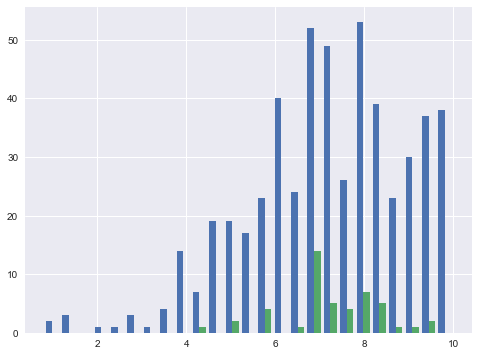

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(scores_by_gender, 25)
plt.show()

## Interactive plot that shows review abstract with mouse over

## Pitchfork Review scores as a function of lexical diversity

In [18]:
def clean_str(s):
    return s.translate(str.maketrans('', '', punctuation)).replace('\u200b', " ").strip().lower()

def lexdiv(s):
    try:
        words = clean_str(s).split(' ')
        return len(set(words))/len(words)
    except:
        return 0

In [19]:
# Calculate lexical diversity for each album
album_lexdivs, album_scores, album_names = [],[],[]
for artist in artists:
    reviews_for_artist = all_reviews[artist['artist']]
    reviews_by_searched_name = dict(zip([review.searched_album for review in all_reviews[artist['artist']]], all_reviews[artist['artist']]))
    artist_album_names = [review.searched_album for review in reviews_for_artist]
    
    # Group together lyrics by album
    albums = {}
    for song in artist['songs']:
        album = song['album']
        if album in artist_album_names:
            if album in albums:
                albums[album] += song['lyrics']
            else:
                albums[album] = song['lyrics']
                
    # Calculate each albums' lexical diversity
    for album, lyrics in albums.items():        
        # Lexical diversity, Pitchfork score, and album name
        album_lexdivs.append(lexdiv(lyrics))
        album_scores.append(reviews_by_searched_name[album].score())
        album_names.append(album)
        
# numpy
album_lexdivs = np.array(album_lexdivs)
album_scores = np.array(album_scores)
album_names = np.array(album_names)                      

In [65]:
help(ax.annotate)

Help on method annotate in module matplotlib.axes._axes:

annotate(*args, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Annotate the point ``xy`` with text ``s``.
    
    Additional kwargs are passed to `~matplotlib.text.Text`.
    
    Parameters
    ----------
    
    s : str
        The text of the annotation
    
    xy : iterable
        Length 2 sequence specifying the *(x,y)* point to annotate
    
    xytext : iterable, optional
        Length 2 sequence specifying the *(x,y)* to place the text
        at.  If None, defaults to ``xy``.
    
    xycoords : str, Artist, Transform, callable or tuple, optional
    
        The coordinate system that ``xy`` is given in.
    
        For a `str` the allowed values are:
    
        =================   ===============================================
        Property            Description
        =================   ===============================================
        'figure points'     points from the l

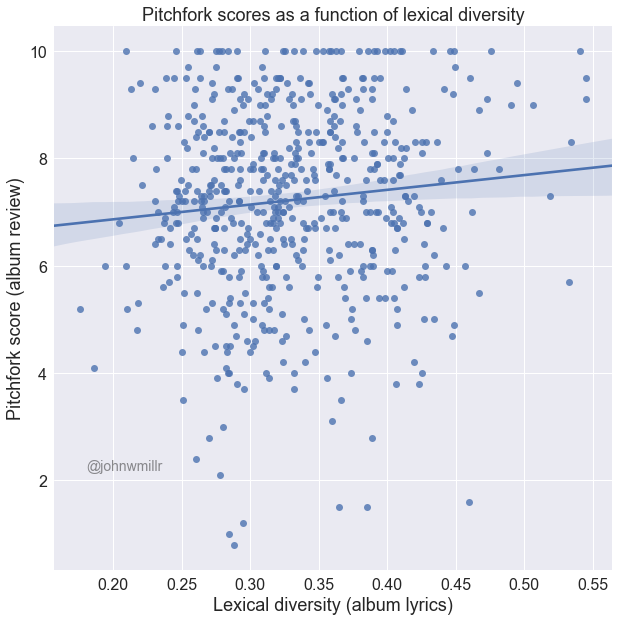

In [90]:
# Plot review score as a function of lexical diversity
fig, ax = plt.subplots(figsize=(10,10))
# ax.plot(album_lexdivs, album_scores, 'ro', alpha=0.4, markersize=10)
sns.regplot(x=album_lexdivs, y=album_scores, ax=ax)
ax.set_xlabel("Lexical diversity (album lyrics)", fontsize=FS)
ax.set_ylabel("Pitchfork score (album review)", fontsize=FS)
for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(FS-2) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FS-2)
ax.set_title("Pitchfork scores as a function of lexical diversity", fontsize=FS)
ax.annotate("@johnwmillr", (0.18,2.2), fontsize=FS-4, alpha=0.5)
# fig.savefig("./figures/pitchfork_score_vs_lexdiv.png", format="png", dpi=300, bbox_inches="tight")
plt.show()